In [25]:
!pip install nltk rouge-score pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import nltk
import gc
from datetime import datetime
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Setup NLTK
try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

In [ ]:
CONFIG = {
    'original_dir': './output_classes',  # Set the folder for original text files
    'ori_dir': './text_c10_translated_gt',  # Folder containing JSON files
    'helsinki_dir': './paralel_disempurnakan',  # Adjust this as per your local folder
    'batch_size': 50,
    'checkpoint_dir': './checkpoints',
    'results_dir': './results',
    'auto_save_interval': 10
}


In [ ]:
def read_json_file(file_path):
    """Membaca file JSON dan mengembalikan data"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            return data['text']  # Assuming 'text' is the key holding the translation
    except Exception as e:
        print(f"Error reading JSON file {file_path}: {e}")
        return None

def save_checkpoint(results, checkpoint_path):
    """Menyimpan checkpoint"""
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(checkpoint_path):
    """Memuat checkpoint"""
    try:
        with open(checkpoint_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

def clean_memory():
    """Membersihkan memori"""
    gc.collect()

def get_file_mappings():
    """Mendapatkan mapping file dari folder JSON"""
    file_mappings = []

    # Traverse the folder containing the JSON files
    for json_file in os.listdir(CONFIG['ori_dir']):
        if json_file.endswith('.json'):
            ori_path = os.path.join(CONFIG['ori_dir'], json_file)
            original_path = os.path.join(CONFIG['original_dir'], json_file.replace('class', 'original_class'))  # Adjust original file mapping

            helsinki_path = os.path.join(CONFIG['helsinki_dir'], json_file.replace('class', 'helsinki_class'))  # Adjust Helsinki file mapping

            if os.path.exists(original_path) and os.path.exists(helsinki_path):
                file_mappings.append({
                    'original': original_path,
                    'ori': ori_path,
                    'helsinki': helsinki_path,
                    'relative_path': json_file
                })

    return file_mappings

def calculate_metrics_single(reference, candidate):
    """Menghitung metrik untuk satu pasang teks"""
    try:
        reference = str(reference).strip().lower()
        candidate = str(candidate).strip().lower()

        if not reference or not candidate:
            return None

        ref_tokens = reference.split()
        cand_tokens = candidate.split()

        if not ref_tokens or not cand_tokens:
            return None

        smoothie = SmoothingFunction().method1

        bleu_scores = {
            'bleu1': sentence_bleu([ref_tokens], cand_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie),
            'bleu2': sentence_bleu([ref_tokens], cand_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie),
            'bleu3': sentence_bleu([ref_tokens], cand_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie),
            'bleu4': sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
        }

        meteor = meteor_score([ref_tokens], cand_tokens)
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference, candidate)

        metrics = {
            **bleu_scores,
            'meteor': meteor,
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure
        }

        return metrics

    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return None


In [ ]:
def process_file_batch(mappings, start_idx, batch_size, results):
    """Memproses batch file"""
    end_idx = min(start_idx + batch_size, len(mappings))

    for idx in range(start_idx, end_idx):
        mapping = mappings[idx]

        if mapping['original'] in results['processed_files']:
            continue

        try:
            original_text = read_json_file(mapping['original'])
            ori_text = read_json_file(mapping['ori'])
            helsinki_text = read_json_file(mapping['helsinki'])

            if original_text and ori_text and helsinki_text:
                ori_metrics = calculate_metrics_single(original_text, ori_text)
                helsinki_metrics = calculate_metrics_single(original_text, helsinki_text)

                if ori_metrics and helsinki_metrics:
                    for metric in ori_metrics:
                        results['ori'][metric].append(ori_metrics[metric])
                        results['helsinki'][metric].append(helsinki_metrics[metric])

                    file_info = {
                        'file': mapping['relative_path'],
                        'original_sample': original_text[:100],
                        'ori_sample': ori_text[:100],
                        'helsinki_sample': helsinki_text[:100],
                        'ori_metrics': ori_metrics,
                        'helsinki_metrics': helsinki_metrics
                    }
                    results['file_details'].append(file_info)
                    results['processed_files'].append(mapping['original'])

            clean_memory()

        except Exception as e:
            print(f"Error processing {mapping['relative_path']}: {str(e)}")
            continue

    return results

def main():
    checkpoints = glob.glob(os.path.join(CONFIG['checkpoint_dir'], '*.pkl'))

    if checkpoints:
        print("\nMelanjutkan dari checkpoint terakhir? (y/n):")
        choice = input().lower()
        if choice == 'y':
            results = load_checkpoint(checkpoints[0])
            print("Checkpoint loaded")
        else:
            results = None
    else:
        results = None

    if results is None:
        results = {
            'ori': {
                'bleu1': [], 'bleu2': [], 'bleu3': [], 'bleu4': [],
                'meteor': [], 'rouge1': [], 'rouge2': [], 'rougeL': []
            },
            'helsinki': {
                'bleu1': [], 'bleu2': [], 'bleu3': [], 'bleu4': [],
                'meteor': [], 'rouge1': [], 'rouge2': [], 'rougeL': []
            },
            'processed_files': [],
            'file_details': []
        }

    print("\nScanning directories...")
    file_mappings = get_file_mappings()
    total_files = len(file_mappings)

    if total_files == 0:
        print("No files to process!")
        return

    print(f"\nFound {total_files} files to process")
    print(f"Already processed: {len(results['processed_files'])}")

    start_time = datetime.now()
    print(f"\nStarting processing at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    try:
        start_idx = len(results['processed_files'])
        checkpoint_path = os.path.join(CONFIG['checkpoint_dir'],
                                    f'checkpoint_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')

        while start_idx < total_files:
            results = process_file_batch(file_mappings, start_idx, CONFIG['batch_size'], results)

            new_processed = len(results['processed_files'])
            if new_processed % CONFIG['auto_save_interval'] == 0:
                save_checkpoint(results, checkpoint_path)
                progress = (new_processed / total_files) * 100
                current_time = datetime.now()
                elapsed = (current_time - start_time).total_seconds()
                speed = new_processed / elapsed if elapsed > 0 else 0

                print(f"\nProgress: {progress:.1f}% ({new_processed}/{total_files})")
                print(f"Processing speed: {speed:.2f} files/second")
                clean_memory()

            start_idx = new_processed

    except KeyboardInterrupt:
        print("\nProses dihentikan oleh user")
        save_checkpoint(results, checkpoint_path)

    except Exception as e:
        print(f"\nError: {str(e)}")
        save_checkpoint(results, checkpoint_path)
        raise e

    finally:
        if len(results['processed_files']) > 0:
            print("\nMenyimpan hasil akhir...")
            metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'meteor', 'rouge1', 'rouge2', 'rougeL']
            metrics_df = pd.DataFrame({
                'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'METEOR', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
                'ori': [np.mean(results['ori'][m]) for m in metrics],
                'Helsinki': [np.mean(results['helsinki'][m]) for m in metrics]
            })
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            metrics_df.to_csv(os.path.join(CONFIG['results_dir'], f'results_{timestamp}.csv'), index=False)
            print("\nHasil akhir:")
            print(metrics_df)

            total_time = datetime.now() - start_time
            print(f"\nTotal waktu pemrosesan: {total_time}")
            print(f"Rata-rata waktu per file: {total_time.total_seconds() / len(results['processed_files']):.2f} detik")

if __name__ == "__main__":
    main()



Scanning directories...


KeyError: 'google_dir'

In [8]:
import json
import os
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
from datetime import datetime

# Setup NLTK
nltk.download('wordnet', quiet=True)

# Konfigurasi file input/output
CONFIG = {
    'pred_file': r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\indo_captions_only.json',
    'ref_file': r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\text_c10_translated_gt.json',
    'results_dir': 'results'
}

os.makedirs(CONFIG['results_dir'], exist_ok=True)

# Fungsi evaluasi per kalimat
def calculate_metrics_single(reference, candidate):
    reference = reference.strip().lower()
    candidate = candidate.strip().lower()

    if not reference or not candidate:
        return None

    ref_tokens = reference.split()
    cand_tokens = candidate.split()
    if not ref_tokens or not cand_tokens:
        return None

    smoothie = SmoothingFunction().method1

    bleu_scores = {
        'bleu1': sentence_bleu([ref_tokens], cand_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie),
        'bleu2': sentence_bleu([ref_tokens], cand_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie),
        'bleu3': sentence_bleu([ref_tokens], cand_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie),
        'bleu4': sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    }

    meteor = meteor_score([ref_tokens], cand_tokens)

    return {**bleu_scores, 'meteor': meteor}

# Load data
with open(CONFIG['pred_file'], 'r', encoding='utf-8') as f:
    pred_data = json.load(f)

with open(CONFIG['ref_file'], 'r', encoding='utf-8') as f:
    ref_data = json.load(f)

# Buat dict untuk pencocokan by filename
pred_dict = {item['filename']: item['captions'] for item in pred_data}
ref_dict = {item['filename']: item['captions'] for item in ref_data}

# Hitung metrik
total = {
    'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0, 'meteor': 0
}
total_count = 0
rows = []

for filename in ref_dict:
    if filename not in pred_dict:
        continue

    preds = pred_dict[filename]
    refs = ref_dict[filename]

    for pred, ref in zip(preds, refs):
        metrics = calculate_metrics_single(ref, pred)
        if metrics:
            rows.append({
                'filename': filename,
                **metrics
            })
            for k in total:
                total[k] += metrics[k]
            total_count += 1

# Rata-rata
avg_metrics = {k: total[k]/total_count for k in total}
print("\n✅ Hasil Rata-rata Metrik:")
for k, v in avg_metrics.items():
    print(f"{k.upper():7}: {v:.4f}")

# Simpan ke CSV
df = pd.DataFrame(rows)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = os.path.join(CONFIG['results_dir'], f'metrics_{timestamp}.csv')
df.to_csv(csv_path, index=False)
print(f"\n📁 Hasil disimpan di: {csv_path}")



✅ Hasil Rata-rata Metrik:
BLEU1  : 0.9814
BLEU2  : 0.9737
BLEU3  : 0.9666
BLEU4  : 0.9586
METEOR : 0.9845

📁 Hasil disimpan di: results\metrics_20250624_115522.csv


In [6]:
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet', quiet=True)

# File input
PRED_FILE = r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\indo_captions_only.json'
GT_FILE = r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\text_c10_translated_gt.json'

# Load prediksi → dict: filename → captions
with open(PRED_FILE, 'r', encoding='utf-8') as f:
    pred_data_raw = json.load(f)

pred_dict = {item['filename']: item['captions'] for item in pred_data_raw}

# Load GT → tetap dalam bentuk list terurut
with open(GT_FILE, 'r', encoding='utf-8') as f:
    gt_data = json.load(f)

# Evaluasi
smoothie = SmoothingFunction().method1
total_bleu1 = total_bleu2 = total_bleu3 = total_bleu4 = total_meteor = 0
total_caption = 0
missing = 0

for gt_item in gt_data:
    filename = gt_item['filename']
    gt_captions = gt_item['captions']

    pred_captions = pred_dict.get(filename)
    if pred_captions is None:
        missing += 1
        continue

    # Cocokkan berdasarkan urutan caption
    for pred, ref in zip(pred_captions, gt_captions):
        pred_tokens = pred.strip().lower().split()
        ref_tokens = ref.strip().lower().split()

        total_bleu1 += sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        total_bleu2 += sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        total_bleu3 += sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        total_bleu4 += sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
        total_meteor += meteor_score([ref_tokens], pred_tokens)


        total_caption += 1

# Rata-rata skor
avg_bleu1 = total_bleu1 / total_caption
avg_bleu2 = total_bleu2 / total_caption
avg_bleu3 = total_bleu3 / total_caption
avg_bleu4 = total_bleu4 / total_caption
avg_meteor = total_meteor / total_caption

# Output
print("\n✅ HASIL EVALUASI BERDASARKAN FILENAME:")
print(f"BLEU-1   : {avg_bleu1:.4f}")
print(f"BLEU-2   : {avg_bleu2:.4f}")
print(f"BLEU-3   : {avg_bleu3:.4f}")
print(f"BLEU-4   : {avg_bleu4:.4f}")
print(f"METEOR   : {avg_meteor:.4f}")
print(f"🟡 Skipped (tidak ditemukan di prediksi): {missing}")



✅ HASIL EVALUASI BERDASARKAN FILENAME:
BLEU-1   : 0.9814
BLEU-2   : 0.9737
BLEU-3   : 0.9666
BLEU-4   : 0.9586
METEOR   : 0.9845
🟡 Skipped (tidak ditemukan di prediksi): 0


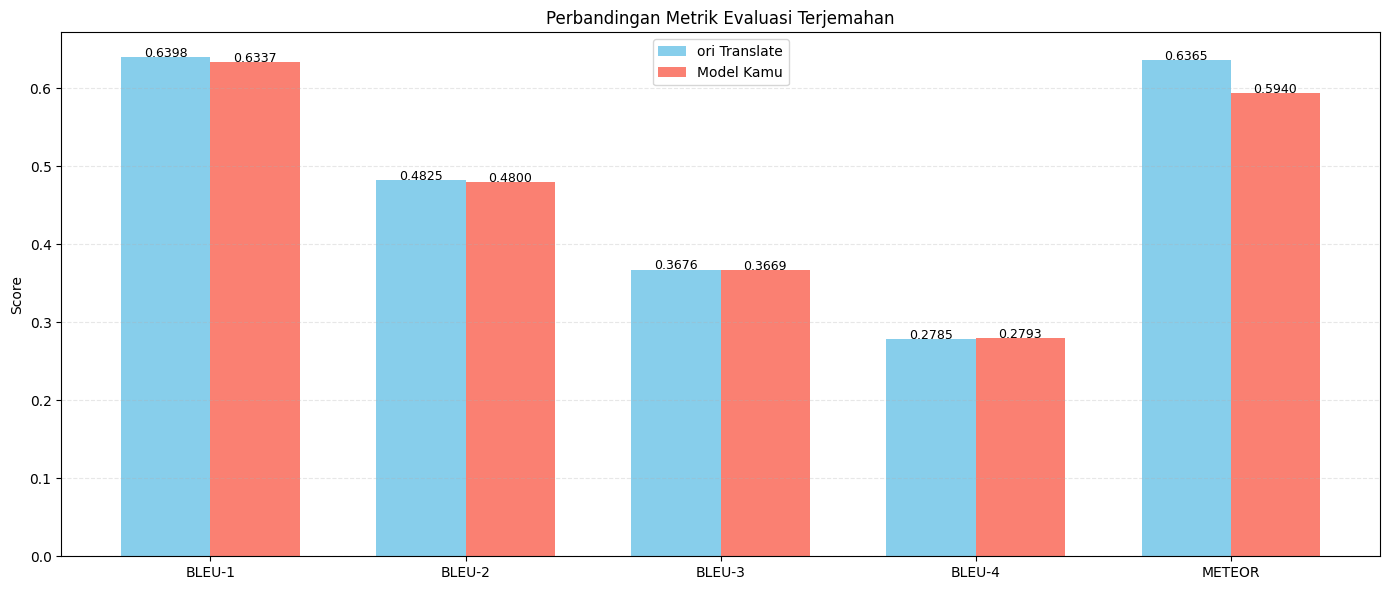

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet', quiet=True)

# === File JSON ===
ORI_FILE = r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\paralel_cub_200_2011_indo_only.json'  # ori Translate
MODEL_FILE = r'D:\DATA CACA\00. College\Skripsi\ta_nmt\data\indo_captions_only.json'       # Model kamu

# === Load JSON ===
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

ori_data = load_json(ORI_FILE)
model_data = load_json(MODEL_FILE)

# === Mapping by filename ===
def map_by_filename(data):
    return {item['filename']: item['captions'] for item in data}

ori_map = map_by_filename(ori_data)
model_map = map_by_filename(model_data)

# === Fungsi Evaluasi
def evaluate(gt_map, pred_map):
    smoothie = SmoothingFunction().method1
    total = {
        'bleu1': 0, 'bleu2': 0, 'bleu3': 0, 'bleu4': 0,
        'meteor': 0, 'count': 0
    }

    for fname in gt_map:
        if fname not in pred_map:
            continue

        gt_captions = gt_map[fname]
        pred_captions = pred_map[fname]

        for ref, hyp in zip(gt_captions, pred_captions):
            ref_tokens = ref.lower().strip().split()
            hyp_tokens = hyp.lower().strip().split()

            total['bleu1'] += sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
            total['bleu2'] += sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
            total['bleu3'] += sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
            total['bleu4'] += sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
            total['meteor'] += meteor_score([ref_tokens], hyp_tokens)
            total['count'] += 1

    return {k: v / total['count'] for k, v in total.items() if k != 'count'}

# === Evaluasi
ori_scores = evaluate(ori_map, model_map)      # Model vs ori Translate (GT dianggap referensi)
model_scores = evaluate(model_map, ori_map)        # ori vs Model (Model dianggap referensi)

# === Siapkan plot
labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'METEOR']
ori_vals = [ori_scores['bleu1'], ori_scores['bleu2'], ori_scores['bleu3'], ori_scores['bleu4'], ori_scores['meteor']]
model_vals = [model_scores['bleu1'], model_scores['bleu2'], model_scores['bleu3'], model_scores['bleu4'], model_scores['meteor']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, ori_vals, width, label='ori Translate', color='skyblue')
plt.bar(x + width/2, model_vals, width, label='Model Kamu', color='salmon')

# Label nilai
for i, v in enumerate(ori_vals):
    plt.text(x[i] - width/2, v + 0.0002, f"{v:.4f}", ha='center', fontsize=9)
for i, v in enumerate(model_vals):
    plt.text(x[i] + width/2, v + 0.0002, f"{v:.4f}", ha='center', fontsize=9)

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Perbandingan Metrik Evaluasi Terjemahan")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()
